# EV Charging Modeling

This notebook builds regression models to predict Energy (El_kWh) and Duration (Duration_hours). It includes feature engineering, encodings, baselines, tree models, evaluation, and figures.

In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

DATA_PATH = 'data/ev_sessions_clean.csv'
FIG_DIR = 'fig/modeling'
os.makedirs(FIG_DIR, exist_ok=True)

print('Paths configured:')
print('  DATA_PATH:', DATA_PATH)
print('  FIG_DIR  :', FIG_DIR)

Paths configured:
  DATA_PATH: data/ev_sessions_clean.csv
  FIG_DIR  : fig/modeling


## 1) Load cleaned data

In [4]:
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
df.head(3)

Shape: (6878, 15)


,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,21.12.2018 10:23,10.0,0.30,0.050000,Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,21.12.2018 10:32,10.0,0.87,0.136667,Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,21.12.2018 11:33,11,21.12.2018 19:46,19.0,29.87,8.216389,Dec,Friday,late morning (9-12),Between 6 and 9 hours


## 2) Feature engineering & encodings
We create cyclical encodings for hour, one-hot for categorical features, and assemble feature matrices for each target.

In [6]:
# Ensure required columns exist or derive them
required = ['El_kWh','Duration_hours','Start_plugin_hour','weekdays_plugin','month_plugin','Garage_ID','User_ID','Plugin_category','Duration_category','date']
missing = [c for c in required if c not in df.columns]
print('Missing columns:', missing)

# Derive 'date' from Start_plugin if missing
if 'date' in missing and 'Start_plugin' in df.columns:
    df['Start_plugin_dt'] = pd.to_datetime(df['Start_plugin'], dayfirst=True, errors='coerce')
    df['date'] = df['Start_plugin_dt'].dt.date
    missing = [c for c in required if c not in df.columns]
    print('After derivation, missing:', missing)

assert len(missing) == 0, 'Cleaned dataset is missing required columns.'

# Cyclical features for hour
df['hour_sin'] = np.sin(2*np.pi*df['Start_plugin_hour']/24)
df['hour_cos'] = np.cos(2*np.pi*df['Start_plugin_hour']/24)

# Chronological sort by date then hour for time-aware splitting
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['date','Start_plugin_hour']).reset_index(drop=True)

# Define feature sets
num_features_common = ['hour_sin','hour_cos']
cat_features_common = ['weekdays_plugin','month_plugin','Garage_ID','Plugin_category','Duration_category']

# For Energy prediction (El_kWh), include duration as predictor
X_energy_num = num_features_common + ['Duration_hours']
X_energy_cat = cat_features_common
y_energy = df['El_kWh']

# For Duration prediction, we DO NOT include El_kWh to avoid leakage; use common features
X_dur_num = num_features_common
X_dur_cat = cat_features_common
y_dur = df['Duration_hours']

print('Feature sets prepared.')

Missing columns: ['date']
After derivation, missing: []
Feature sets prepared.


## 3) Train/test split (chronological)

In [10]:
# Chronological split: first 80% train, last 20% test
n = len(df)
split_idx = int(n * 0.8)

def split_features(X_num, X_cat, target):
    X_num_mat = df[X_num]
    X_cat_mat = df[X_cat]
    # Drop rows with NaN in target (and align features accordingly)
    mask = target.notna()
    X_num_mat = X_num_mat[mask]
    X_cat_mat = X_cat_mat[mask]
    target = target[mask]

    X_num_train, X_num_test = X_num_mat.iloc[:split_idx], X_num_mat.iloc[split_idx:]
    X_cat_train, X_cat_test = X_cat_mat.iloc[:split_idx], X_cat_mat.iloc[split_idx:]
    y_train, y_test = target.iloc[:split_idx], target.iloc[split_idx:]
    return X_num_train, X_num_test, X_cat_train, X_cat_test, y_train, y_test

Xn_e_tr, Xn_e_te, Xc_e_tr, Xc_e_te, y_e_tr, y_e_te = split_features(X_energy_num, X_energy_cat, y_energy)
Xn_d_tr, Xn_d_te, Xc_d_tr, Xc_d_te, y_d_tr, y_d_te = split_features(X_dur_num, X_dur_cat, y_dur)

print('Energy split:', Xn_e_tr.shape, Xn_e_te.shape, y_e_tr.shape, y_e_te.shape)
print('Duration split:', Xn_d_tr.shape, Xn_d_te.shape, y_d_tr.shape, y_d_te.shape)

Energy split: (5502, 3) (1376, 3) (5502,) (1376,)
Duration split: (5502, 2) (1342, 2) (5502,) (1342,)


## 4) Baselines & models
We compare Ridge (linear) and RandomForest (tree) for both targets.

In [11]:
from sklearn.impute import SimpleImputer

def metrics(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

def make_pipeline(X_num_cols, X_cat_cols, model):
    ct = ColumnTransformer([
        ('num', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='median')),
            ('pass', 'passthrough')
        ]), X_num_cols),
        ('cat', Pipeline(steps=[
            ('impute', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), X_cat_cols)
    ])
    pipe = Pipeline([('prep', ct), ('model', model)])
    return pipe

results = []

# Energy: Ridge
pipe_e_ridge = make_pipeline(X_energy_num, X_energy_cat, Ridge(alpha=1.0))
pipe_e_ridge.fit(pd.concat([Xn_e_tr, Xc_e_tr], axis=1), y_e_tr)
pred_e_ridge = pipe_e_ridge.predict(pd.concat([Xn_e_te, Xc_e_te], axis=1))
res_e_ridge = metrics(y_e_te, pred_e_ridge)
res_e_ridge.update({'Target':'El_kWh','Model':'Ridge'})
results.append(res_e_ridge)

# Energy: RandomForest
pipe_e_rf = make_pipeline(X_energy_num, X_energy_cat, RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42))
pipe_e_rf.fit(pd.concat([Xn_e_tr, Xc_e_tr], axis=1), y_e_tr)
pred_e_rf = pipe_e_rf.predict(pd.concat([Xn_e_te, Xc_e_te], axis=1))
res_e_rf = metrics(y_e_te, pred_e_rf)
res_e_rf.update({'Target':'El_kWh','Model':'RandomForest'})
results.append(res_e_rf)

# Duration: Ridge
pipe_d_ridge = make_pipeline(X_dur_num, X_dur_cat, Ridge(alpha=1.0))
pipe_d_ridge.fit(pd.concat([Xn_d_tr, Xc_d_tr], axis=1), y_d_tr)
pred_d_ridge = pipe_d_ridge.predict(pd.concat([Xn_d_te, Xc_d_te], axis=1))
res_d_ridge = metrics(y_d_te, pred_d_ridge)
res_d_ridge.update({'Target':'Duration_hours','Model':'Ridge'})
results.append(res_d_ridge)

# Duration: RandomForest
pipe_d_rf = make_pipeline(X_dur_num, X_dur_cat, RandomForestRegressor(n_estimators=300, max_depth=None, random_state=42))
pipe_d_rf.fit(pd.concat([Xn_d_tr, Xc_d_tr], axis=1), y_d_tr)
pred_d_rf = pipe_d_rf.predict(pd.concat([Xn_d_te, Xc_d_te], axis=1))
res_d_rf = metrics(y_d_te, pred_d_rf)
res_d_rf.update({'Target':'Duration_hours','Model':'RandomForest'})
results.append(res_d_rf)

results_df = pd.DataFrame(results)
print(results_df)

# Save metrics table
results_df.to_csv(os.path.join(FIG_DIR, 'metrics.csv'), index=False)
results_df

        RMSE       MAE        R2          Target         Model
0  10.486313  6.947627  0.224889          El_kWh         Ridge
1  10.413475  6.589582  0.235619          El_kWh  RandomForest
2   8.451103  3.455521  0.601152  Duration_hours         Ridge
3  11.378572  3.447042  0.276970  Duration_hours  RandomForest


,RMSE,MAE,R2,Target,Model
0,10.486313,6.947627,0.224889,El_kWh,Ridge
1,10.413475,6.589582,0.235619,El_kWh,RandomForest
2,8.451103,3.455521,0.601152,Duration_hours,Ridge
3,11.378572,3.447042,0.276970,Duration_hours,RandomForest


## 5) Figures: Predictions vs Actuals & Residuals

/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
2025-12-03 21:39:09.858335: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-12-03 21:39:09.858409: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-03 21:39:09.858417: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.88 GB
2025-12-03 21:39:09.858596: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-03 21:39:09.858611: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: MET

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/Users/cyrils/Developer/Python/NeuralNetworks/.venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Results after adding KerasNN:
        RMSE       MAE        R2          Target         Model
0  10.486313  6.947627  0.224889          El_kWh         Ridge
1  10.413475  6.589582  0.235619          El_kWh  RandomForest
2   8.451103  3.455521  0.601152  Duration_hours         Ridge
3  11.378572  3.447042  0.276970  Duration_hours  RandomForest
4  10.956330  7.007983  0.153848          El_kWh       XGBoost
5  13.468669  4.184535 -0.013048  Duration_hours       XGBoost
6  10.417185  6.754813  0.235075          El_kWh       KerasNN
7   8.377305  3.247964  0.608087  Duration_hours       KerasNN


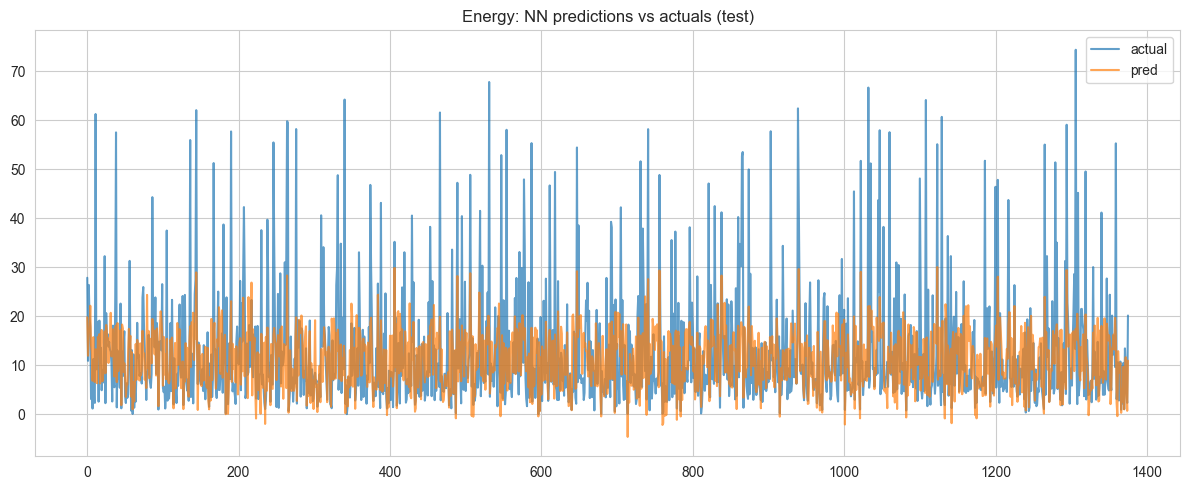

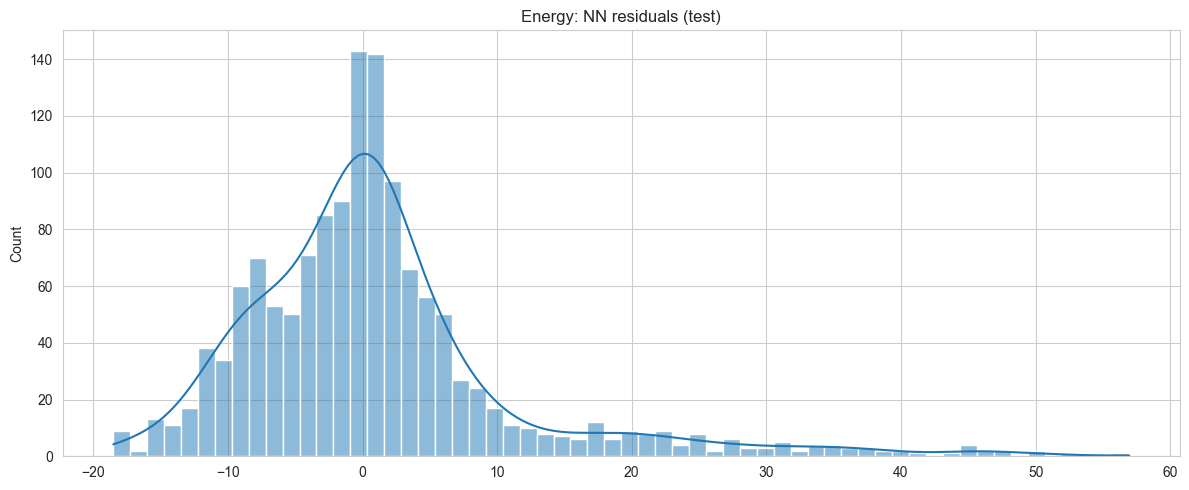

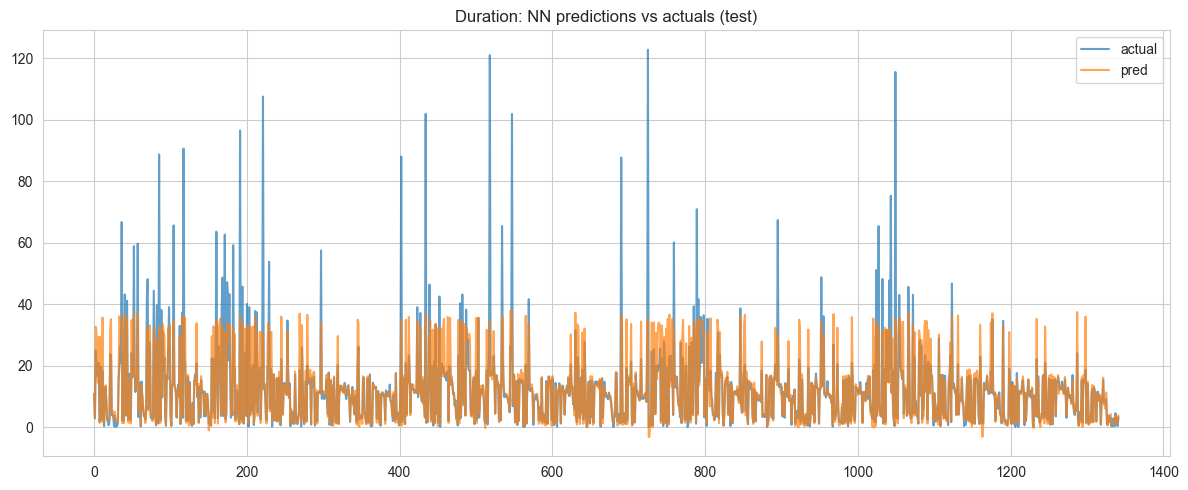

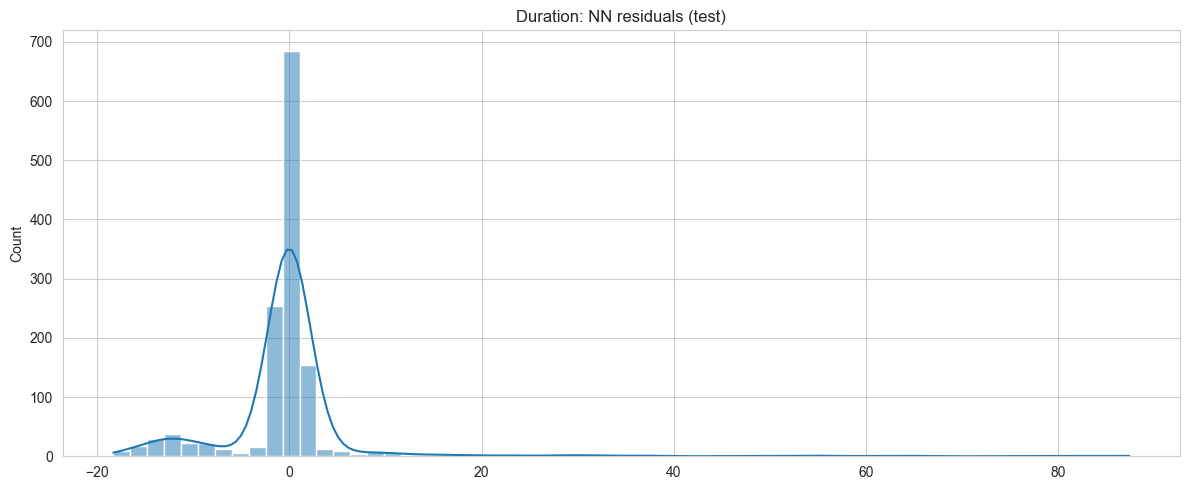

In [18]:
## 5b) Neural Network (Keras) baselines per Lecture 3 Part 2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

def build_keras_reg(input_dim, hidden_units=32, activation='tanh'):
    model = Sequential([
        InputLayer(input_shape=(input_dim,)),
        Dense(hidden_units, activation=activation),
        Dense(1)
    ])
    return model

# Prepare numpy with unique columns

def prepare_numpy(X_num_cols, X_cat_cols, X_df):
    # ensure unique ordered columns from provided lists
    X_num_cols = list(dict.fromkeys(X_num_cols))
    X_cat_cols = list(dict.fromkeys(X_cat_cols))
    ct = ColumnTransformer([
        ('num', Pipeline(steps=[('impute', SimpleImputer(strategy='median'))]), X_num_cols),
        ('cat', Pipeline(steps=[('impute', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))]), X_cat_cols)
    ])
    X = ct.fit_transform(X_df[X_num_cols + X_cat_cols])
    return X, ct

def train_keras(X_train, y_train, X_val, y_val, optimizer='adam', lr=1e-3, activation='tanh', epochs=60, batch_size=64):
    input_dim = X_train.shape[1]
    model = build_keras_reg(input_dim=input_dim, hidden_units=32, activation=activation)
    opt = Adam(learning_rate=lr) if optimizer=='adam' else SGD(learning_rate=lr, momentum=0.9)
    model.compile(optimizer=opt, loss='mse', metrics=['mae'])
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])
    return model, history

# Energy NN
X_e_tr_df = pd.concat([Xn_e_tr, Xc_e_tr], axis=1)
X_e_te_df = pd.concat([Xn_e_te, Xc_e_te], axis=1)
X_e_tr_np, ct_e = prepare_numpy(X_energy_num, X_energy_cat, X_e_tr_df)
X_e_te_np = ct_e.transform(X_e_te_df[X_energy_num + X_energy_cat])
model_e, hist_e = train_keras(X_e_tr_np, y_e_tr.values, X_e_te_np, y_e_te.values, optimizer='adam', lr=1e-3, activation='tanh', epochs=60, batch_size=64)
pred_e_nn = model_e.predict(X_e_te_np).ravel()
res_e_nn = metrics(y_e_te, pred_e_nn)
res_e_nn.update({'Target':'El_kWh','Model':'KerasNN'})
results.append(res_e_nn)

# Duration NN
X_d_tr_df = pd.concat([Xn_d_tr, Xc_d_tr], axis=1)
X_d_te_df = pd.concat([Xn_d_te, Xc_d_te], axis=1)
X_d_tr_np, ct_d = prepare_numpy(X_dur_num, X_dur_cat, X_d_tr_df)
X_d_te_np = ct_d.transform(X_d_te_df[X_dur_num + X_dur_cat])
model_d, hist_d = train_keras(X_d_tr_np, y_d_tr.values, X_d_te_np, y_d_te.values, optimizer='adam', lr=1e-3, activation='tanh', epochs=60, batch_size=64)
pred_d_nn = model_d.predict(X_d_te_np).ravel()
res_d_nn = metrics(y_d_te, pred_d_nn)
res_d_nn.update({'Target':'Duration_hours','Model':'KerasNN'})
results.append(res_d_nn)

# Update and save metrics with NN
results_df = pd.DataFrame(results)
print('\nResults after adding KerasNN:')
print(results_df)
results_df.to_csv(os.path.join(FIG_DIR, 'metrics.csv'), index=False)
plot_pred_actual(y_e_te, pred_e_nn, 'Energy: NN predictions vs actuals (test)', 'energy_nn_pred_vs_actual.png')
plot_residuals(y_e_te, pred_e_nn, 'Energy: NN residuals (test)', 'energy_nn_residuals.png')
plot_pred_actual(y_d_te, pred_d_nn, 'Duration: NN predictions vs actuals (test)', 'duration_nn_pred_vs_actual.png')
plot_residuals(y_d_te, pred_d_nn, 'Duration: NN residuals (test)', 'duration_nn_residuals.png')

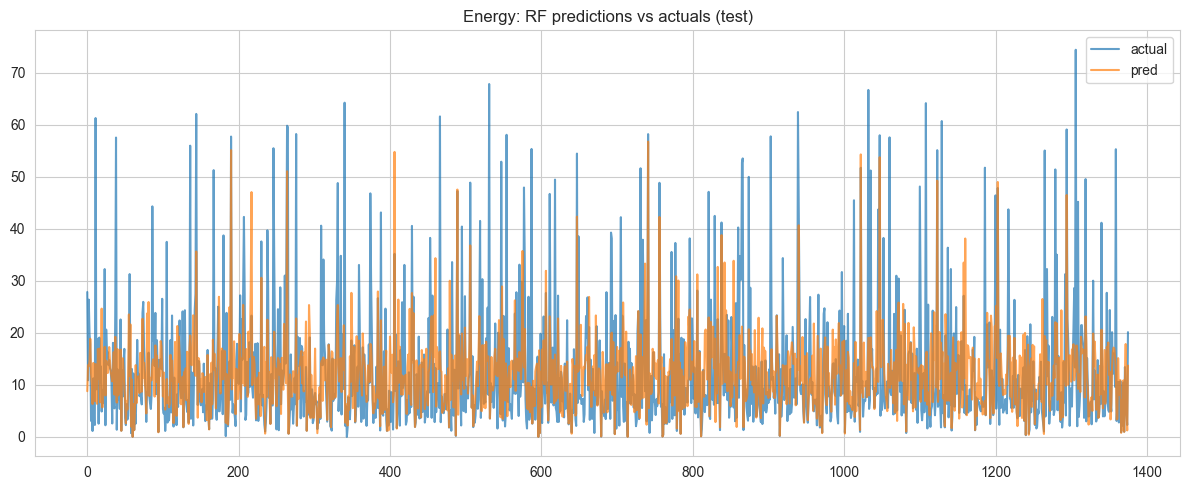

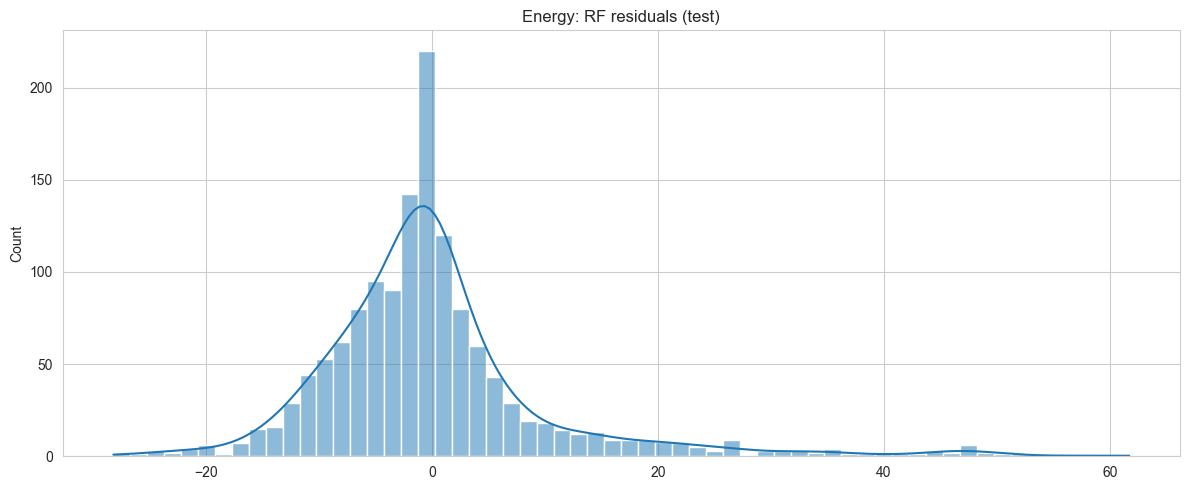

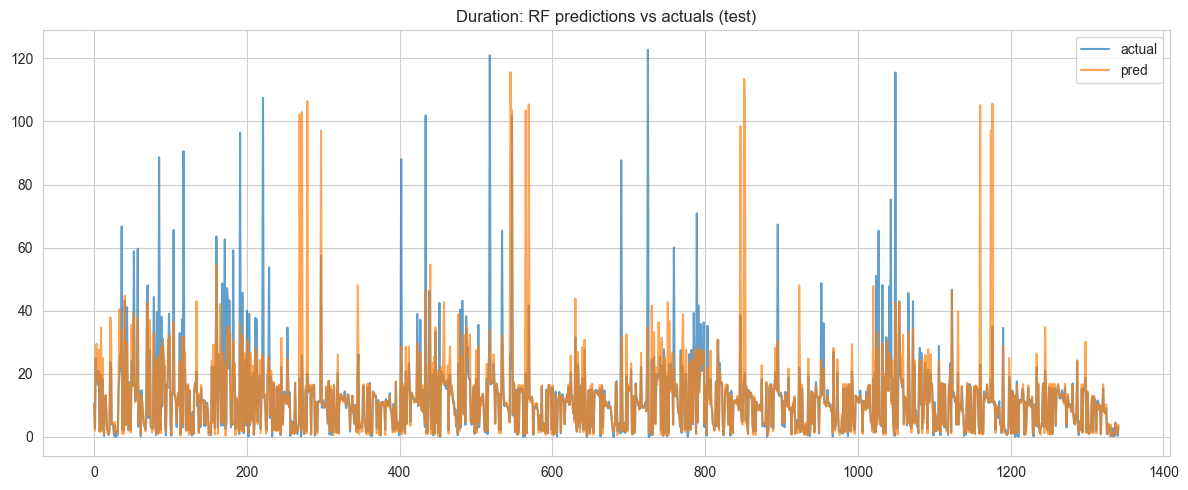

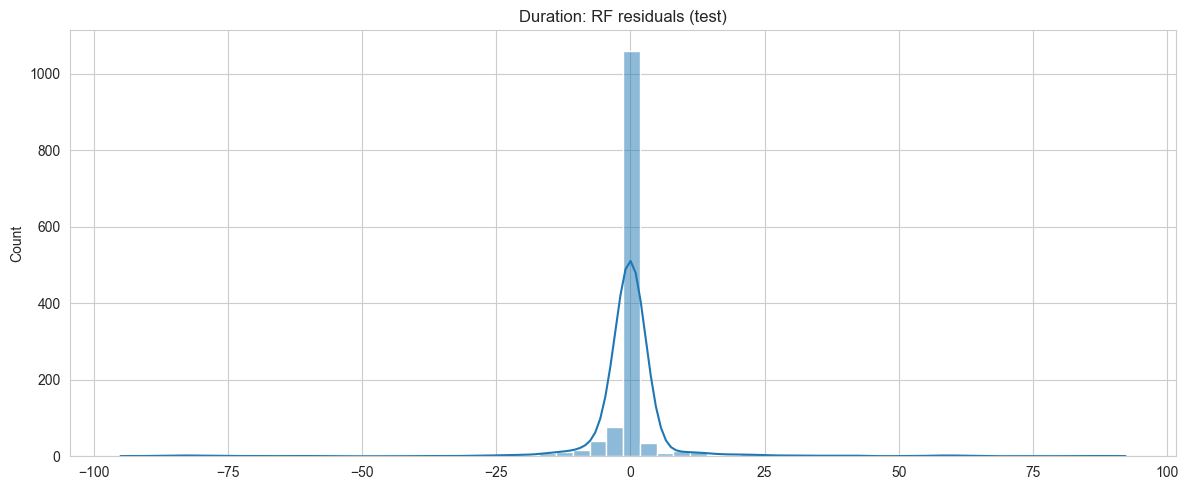

In [12]:
def plot_pred_actual(y_true, y_pred, title, fname):
    plt.figure(figsize=(12,5))
    plt.plot(y_true.values, label='actual', alpha=0.7)
    plt.plot(y_pred, label='pred', alpha=0.7)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, fname), dpi=120)
    plt.show()

def plot_residuals(y_true, y_pred, title, fname):
    resid = y_true.values - y_pred
    plt.figure(figsize=(12,5))
    sns.histplot(resid, bins=60, kde=True)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, fname), dpi=120)
    plt.show()

# Energy
plot_pred_actual(y_e_te, pred_e_rf, 'Energy: RF predictions vs actuals (test)', 'energy_rf_pred_vs_actual.png')
plot_residuals(y_e_te, pred_e_rf, 'Energy: RF residuals (test)', 'energy_rf_residuals.png')

# Duration
plot_pred_actual(y_d_te, pred_d_rf, 'Duration: RF predictions vs actuals (test)', 'duration_rf_pred_vs_actual.png')
plot_residuals(y_d_te, pred_d_rf, 'Duration: RF residuals (test)', 'duration_rf_residuals.png')

## 6) Month-wise metrics (robustness check incl. February)

In [15]:
# Attach predictions back with indices
# Note: duration test set length may differ slightly after NaN filtering

df_test_energy = df.iloc[split_idx:].copy()
df_test_energy = df_test_energy.assign(pred_energy_rf = pred_e_rf)

# Align duration predictions with the last part of df for which y_d_te was built
len_d_test = len(y_d_te)
df_test_duration = df.iloc[-len_d_test:].copy()
df_test_duration = df_test_duration.assign(pred_duration_rf = pred_d_rf)


def monthwise_metrics(df_in, y_true_col, y_pred_col, month_col):
    out = []
    for m, grp in df_in.groupby(month_col):
        # Drop NaNs before computing metrics
        sub = grp[[y_true_col, y_pred_col]].dropna()
        if len(sub) == 0:
            continue
        yt = sub[y_true_col]
        yp = sub[y_pred_col]
        out.append({
            'month': m,
            'RMSE': math.sqrt(mean_squared_error(yt, yp)),
            'MAE': mean_absolute_error(yt, yp),
            'R2': r2_score(yt, yp)
        })
    return pd.DataFrame(out).sort_values('month')

mw_energy = monthwise_metrics(df_test_energy, 'El_kWh','pred_energy_rf','month_plugin')
mw_duration = monthwise_metrics(df_test_duration, 'Duration_hours','pred_duration_rf','month_plugin')
print('Month-wise Energy metrics:\n', mw_energy)
print('\nMonth-wise Duration metrics:\n', mw_duration)

mw_energy.to_csv(os.path.join(FIG_DIR, 'monthwise_energy_metrics.csv'), index=False)
mw_duration.to_csv(os.path.join(FIG_DIR, 'monthwise_duration_metrics.csv'), index=False)

mw_energy, mw_duration

Month-wise Energy metrics:
   month       RMSE       MAE        R2
0   Dec   9.453681  5.753520  0.148766
1   Jan  10.502171  6.670921  0.241637

Month-wise Duration metrics:
   month       RMSE        MAE        R2
0   Dec  21.482262  15.594763 -0.577632
1   Jan  13.605207   5.025659 -0.082404


(  month       RMSE       MAE        R2
 0   Dec   9.453681  5.753520  0.148766
 1   Jan  10.502171  6.670921  0.241637,
   month       RMSE        MAE        R2
 0   Dec  21.482262  15.594763 -0.577632
 1   Jan  13.605207   5.025659 -0.082404)

## 7) Notes
- Use LightGBM/XGBoost next for potential performance gains.
- Consider user/location aggregation features (rolling means) for improvement.
- Keep chronological CV to avoid leakage.
- Review February performance; only adjust if metrics are consistently poor.


Updated results with XGBoost:
        RMSE       MAE        R2          Target         Model
0  10.486313  6.947627  0.224889          El_kWh         Ridge
1  10.413475  6.589582  0.235619          El_kWh  RandomForest
2   8.451103  3.455521  0.601152  Duration_hours         Ridge
3  11.378572  3.447042  0.276970  Duration_hours  RandomForest
4  10.956330  7.007983  0.153848          El_kWh       XGBoost
5  13.468669  4.184535 -0.013048  Duration_hours       XGBoost


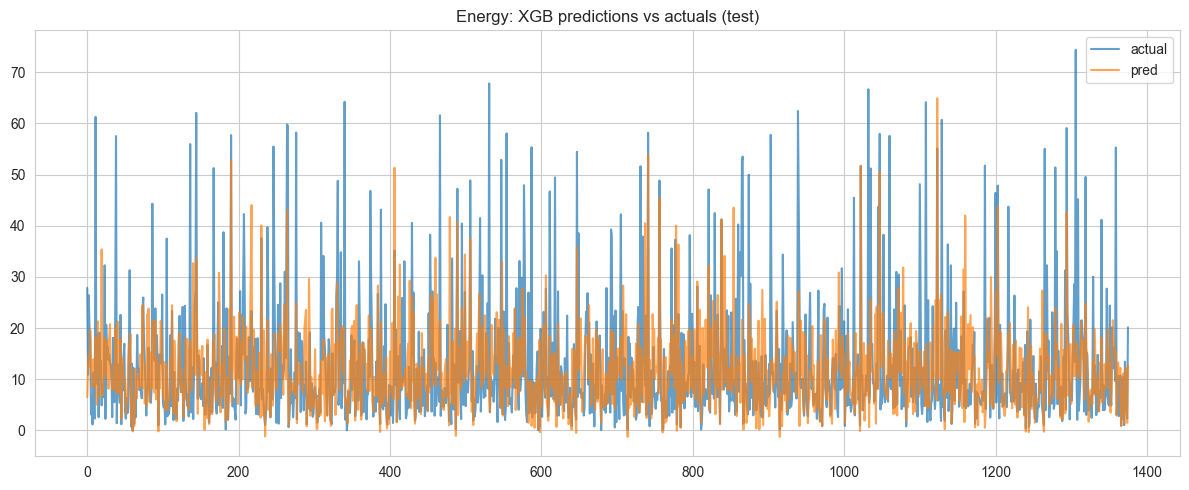

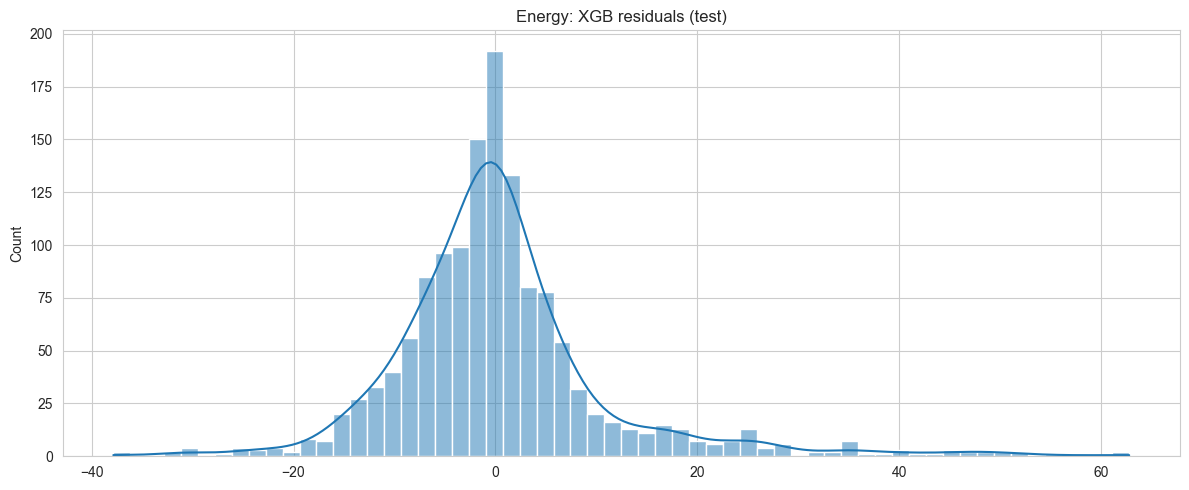

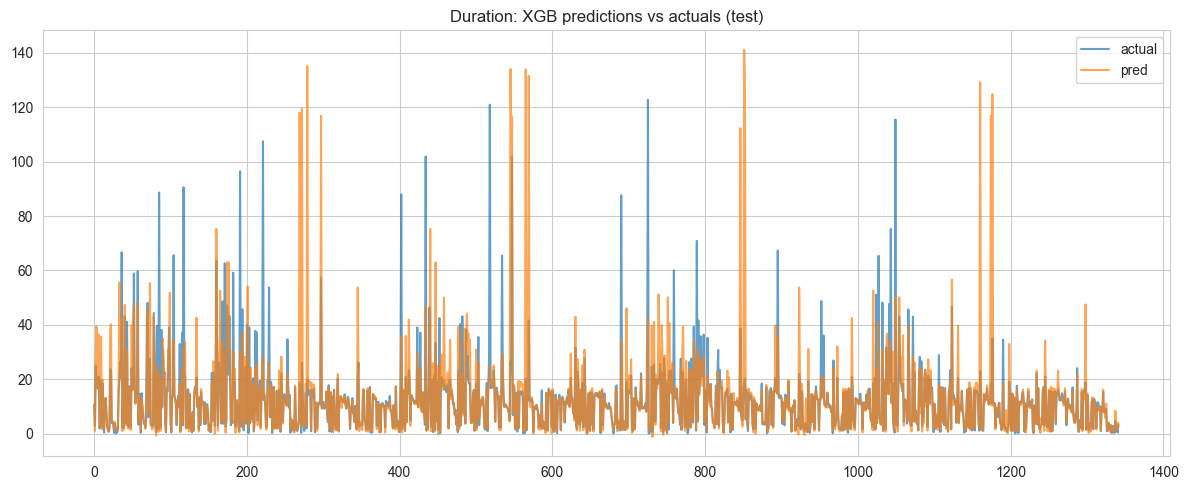

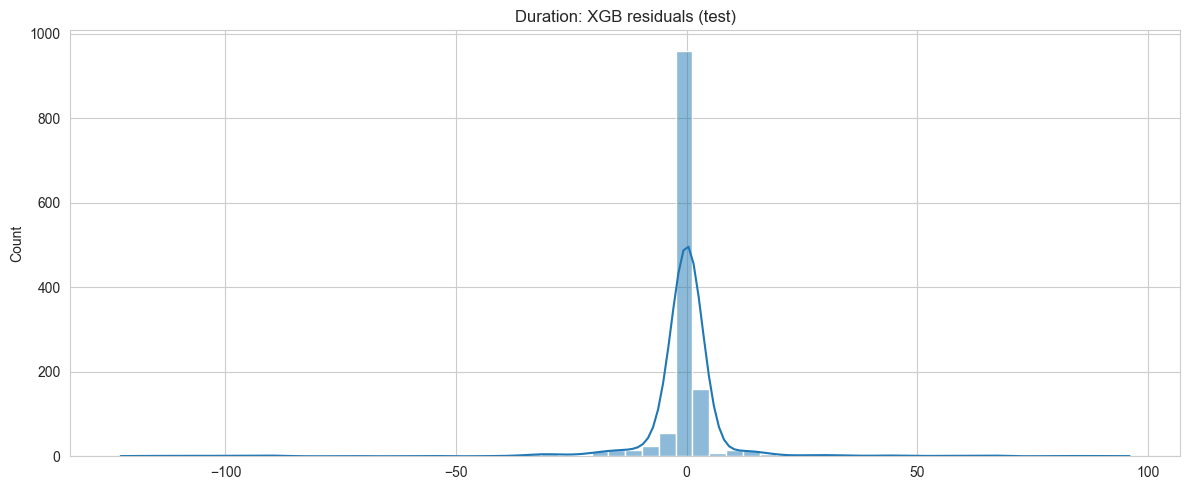

In [16]:
# 8) XGBoost models (if xgboost available)

try:
    from xgboost import XGBRegressor
    has_xgb = True
except Exception as e:
    print('XGBoost not available in environment:', e)
    has_xgb = False

xgb_results = []
if has_xgb:
    # Energy: XGB
    pipe_e_xgb = make_pipeline(X_energy_num, X_energy_cat, 
                               XGBRegressor(n_estimators=600, max_depth=8, learning_rate=0.05,
                                            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1))
    pipe_e_xgb.fit(pd.concat([Xn_e_tr, Xc_e_tr], axis=1), y_e_tr)
    pred_e_xgb = pipe_e_xgb.predict(pd.concat([Xn_e_te, Xc_e_te], axis=1))
    res_e_xgb = metrics(y_e_te, pred_e_xgb)
    res_e_xgb.update({'Target':'El_kWh','Model':'XGBoost'})
    results.append(res_e_xgb)

    # Duration: XGB
    pipe_d_xgb = make_pipeline(X_dur_num, X_dur_cat, 
                               XGBRegressor(n_estimators=600, max_depth=8, learning_rate=0.05,
                                            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1))
    pipe_d_xgb.fit(pd.concat([Xn_d_tr, Xc_d_tr], axis=1), y_d_tr)
    pred_d_xgb = pipe_d_xgb.predict(pd.concat([Xn_d_te, Xc_d_te], axis=1))
    res_d_xgb = metrics(y_d_te, pred_d_xgb)
    res_d_xgb.update({'Target':'Duration_hours','Model':'XGBoost'})
    results.append(res_d_xgb)

    # Update results_df
    results_df = pd.DataFrame(results)
    print('\nUpdated results with XGBoost:')
    print(results_df)
    results_df.to_csv(os.path.join(FIG_DIR, 'metrics.csv'), index=False)

    # Save XGB figures
    plot_pred_actual(y_e_te, pred_e_xgb, 'Energy: XGB predictions vs actuals (test)', 'energy_xgb_pred_vs_actual.png')
    plot_residuals(y_e_te, pred_e_xgb, 'Energy: XGB residuals (test)', 'energy_xgb_residuals.png')

    plot_pred_actual(y_d_te, pred_d_xgb, 'Duration: XGB predictions vs actuals (test)', 'duration_xgb_pred_vs_actual.png')
    plot_residuals(y_d_te, pred_d_xgb, 'Duration: XGB residuals (test)', 'duration_xgb_residuals.png')
else:
    print('Skipping XGBoost modeling due to missing package.')